In [1]:
# My Jupyter Lab Notebook, Explore Data Analysis
## Author: Pham Van Thai
### Date: 25, Jan, 2024

## I. Data Overview

In [2]:
# import the necessary libraries

In [3]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from fuzzywuzzy import fuzz

import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

from sklearn.feature_extraction.text import CountVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [4]:
%run utils.ipynb

[nltk_data] Downloading package stopwords to /home/dev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Load the train dataset for processing.
df = pd.read_csv('../Medical-Abstracts-TC-Corpus/medical_tc_train.csv')
df.head()

condition_label                                   medical_abstract
0                5  Tissue changes around loose prostheses. A cani...
1                1  Neuropeptide Y and neuron-specific enolase lev...
2                2  Sexually transmitted diseases of the colon, re...
3                1  Lipolytic factors associated with murine and h...
4                3  Does carotid restenosis predict an increased r...

In [6]:
# Check for null values in the dataset.
df.medical_abstract.isnull().sum()

0

In [7]:
# Find the total number of class IDs.
df.condition_label.unique()

array([5, 1, 2, 3, 4])

In [8]:
# Check values of Duplicate
num_duplicates = df.medical_abstract.duplicated()
df_duplicate = df[num_duplicates]
df_duplicate.head()

condition_label                                   medical_abstract
505                5  Serum and tissue magnesium concentrations in p...
563                3  Coronary bypass surgery: is the operation diff...
580                4  Morbidity, mortality, and quality of life for ...
597                3  Observations on the pathophysiology of Nelson'...
708                4  Venous infarction following the interhemispher...

In [9]:
num_duplicates.sum()

2105

In [10]:
df_duplicate = df_duplicate.sort_values(by='medical_abstract').reset_index(drop=True)

In [11]:
df_duplicate.head(20)

condition_label                                   medical_abstract
0                 5  'Locked-in syndrome' for 27 years following a ...
1                 1  'Locked-in syndrome' for 27 years following a ...
2                 4  (A)typical symptoms during single needle dialy...
3                 2  (A)typical symptoms during single needle dialy...
4                 3  99TCm-HMPAO SPECT studies in traumatic intrace...
5                 4  A 5.3-kb deletion including exon XIII of the p...
6                 3  A case of amnesia after excision of the septum...
7                 5  A case of amnesia after excision of the septum...
8                 1  A case of cecocolic intussusception with compl...
9                 2  A case of lisinopril-induced lithium toxicity ...
10                2  A case of severe pancytopenia caused by ibupro...
11                3  A case of unilateral posterior ischemic optic ...
12                3  A cellist with arm pain: thermal asymmetry in ...
13                4  A cellist with arm pain: thermal asymmetry in ...
14                5  A clinical pilot study combining surgery with ...
15                3  A clinical triad to diagnose paraneoplastic re...
16                4  A clinically applicable method for long-term s...
17                2  A clinicopathologic study of the eyes in famil...
18                5  A clinicopathological study of the paraneoplas...
19                3  A comparative trial of three agents in the tre...

* __importance__</br>
This duplicated value will be analyzed in conjunction with the Jaccard Score to determine whether it correctly matches 2105 multi-label values or not.
This will be further clarified in the analysis below.

In [12]:
# Modify class IDs such that the first value is 0, and create a mapping with names.
df.condition_label = df.condition_label.apply(lambda x: x-1)
class_mapping = {"0": "Neoplasms",
                 "1": "Digestive system diseases",
                 "2": "Nervous system diseases",
                 "3": "Cardiovascular diseases",
                 "4": "General pathological conditions"}

In [13]:
# Counting all values for each class.
df.condition_label.value_counts()

condition_label
4    3844
0    2530
3    2441
2    1540
1    1195
Name: count, dtype: int64

In [14]:
df.head()

condition_label                                   medical_abstract
0                4  Tissue changes around loose prostheses. A cani...
1                0  Neuropeptide Y and neuron-specific enolase lev...
2                1  Sexually transmitted diseases of the colon, re...
3                0  Lipolytic factors associated with murine and h...
4                2  Does carotid restenosis predict an increased r...

## II. Explore data analysis.

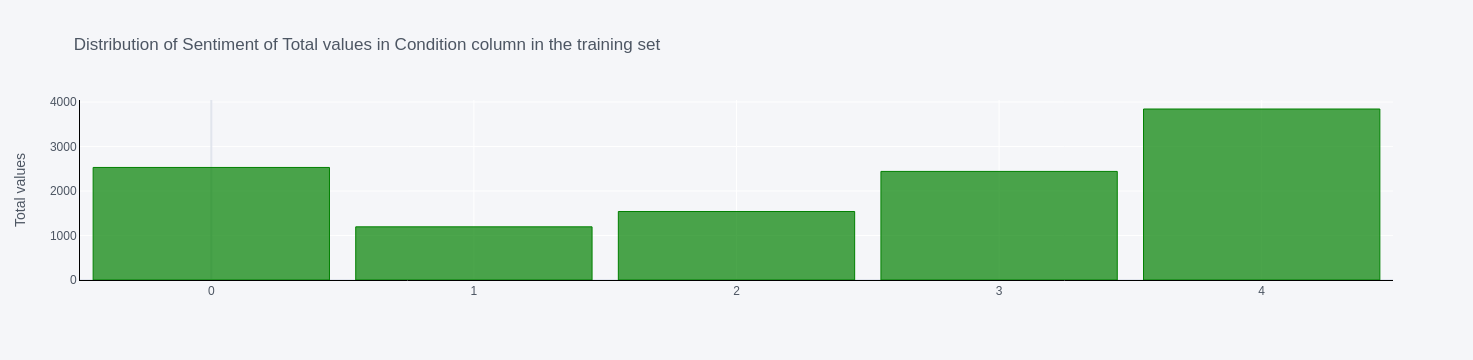

In [15]:
# Show a bar graph to provide an overview of the total data.
df['condition_label'].value_counts(normalize=False).iplot(kind='bar',
                                                        yTitle='Total values', 
                                                        linecolor='black', 
                                                        opacity=0.7,
                                                        color='green',
                                                        theme='pearl',
                                                        bargap=0.1,
                                                        gridcolor='white',
                                                        title='Distribution of Sentiment of Total values in Condition column in the training set')

In [16]:
# Split the DataFrame into separate DataFrames for each class.

df_class_0 = df[df.condition_label==0]
df_class_1 = df[df.condition_label==1]
df_class_2 = df[df.condition_label==2]
df_class_3 = df[df.condition_label==3]
df_class_4 = df[df.condition_label==4]

df_class_0.reset_index(inplace=False, drop=True)
df_class_1.reset_index(inplace=False, drop=True)
df_class_2.reset_index(inplace=False, drop=True)
df_class_3.reset_index(inplace=False, drop=True)
df_class_4.reset_index(inplace=False, drop=True)

condition_label                                   medical_abstract
0                   4  Tissue changes around loose prostheses. A cani...
1                   4  Color Doppler diagnosis of mechanical prosthet...
2                   4  Noninvasive diagnosis of right-sided extracard...
3                   4  Closure of a bronchopleural fistula with bronc...
4                   4  In vitro and in vivo effects within the corona...
...               ...                                                ...
3839                4  Placebo controlled trial of xamoterol versus d...
3840                4  Evidence that tumor necrosis factor plays a pa...
3841                4  Pregnancy outcome in hematologic malignancies....
3842                4  Safety of the transbronchial biopsy in outpati...
3843                4  Recurrent thoracic outlet syndrome after first...

[3844 rows x 2 columns]

In [17]:
df_class_4.head()

condition_label                                   medical_abstract
0                 4  Tissue changes around loose prostheses. A cani...
8                 4  Color Doppler diagnosis of mechanical prosthet...
9                 4  Noninvasive diagnosis of right-sided extracard...
12                4  Closure of a bronchopleural fistula with bronc...
18                4  In vitro and in vivo effects within the corona...

In [18]:
# View Shape of child df
df_class_0.shape, df_class_1.shape, df_class_2.shape, df_class_3.shape, df_class_4.shape

((2530, 2), (1195, 2), (1540, 2), (2441, 2), (3844, 2))

In [19]:
# Find the index and Jaccard score of two columns within a DataFrame for class 1
# Default Jaccard threshold is 0.8

a_id_df_class_0_1, a_id_df_class_1, j_score0 = data_filter_parallel(df_class_0, df_class_1)

# Find the index and Jaccard score of two columns within a DataFrame for class 1
a_id_df_class_0_2, a_id_df_class_2, j_score1 = data_filter_parallel(df_class_0, df_class_2)

# Find the index and Jaccard score of two columns within a DataFrame for class 1
a_id_df_class_0_3, a_id_df_class_3, j_score2 = data_filter_parallel(df_class_0, df_class_3)

# Find the index and Jaccard score of two columns within a DataFrame for class 1
a_id_df_class_0_4, a_id_df_class_4, j_score3 = data_filter_parallel(df_class_0, df_class_4)

#Find the index and Jaccard score of two columns within a DataFrame for class 2
b_id_df_class_1_1, b_id_df_class_2, j_score4 = data_filter_parallel(df_class_1, df_class_2)

# Find the index and Jaccard score of two columns within a DataFrame for class 2
b_id_df_class_1_2, b_id_df_class_3, j_score5 = data_filter_parallel(df_class_1, df_class_3)

# Find the index and Jaccard score of two columns within a DataFrame for class 2
b_id_df_class_1_3, b_id_df_class_4, j_score6 = data_filter_parallel(df_class_1, df_class_4)

# Find the index and Jaccard score of two columns within a DataFrame for class 3
c_id_df_class_2_1, c_id_df_class_3, j_score7 = data_filter_parallel(df_class_2, df_class_3)

# Find the index and Jaccard score of two columns within a DataFrame for class 3
c_id_df_class_2_2, c_id_df_class_4, j_score8 = data_filter_parallel(df_class_2, df_class_4)

# Find the index and Jaccard score of two columns within a DataFrame for class 4
d_id_df_class_3_1, d_id_df_class_4, j_score9 = data_filter_parallel(df_class_3, df_class_4)

Processing: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2441/2441 [02:32<00:00, 15.98it/s]


In [20]:
# Check if all values of the Jaccard score are the same.
check_replace_values(j_score0)

Is all the same : True 	 Total values:  125


In [21]:
check_replace_values(j_score1)

Is all the same : True 	 Total values:  126


In [22]:
check_replace_values(j_score2)

Is all the same : True 	 Total values:  69


In [23]:
check_replace_values(j_score3)

Is all the same : True 	 Total values:  396


In [24]:
check_replace_values(j_score4)

Is all the same : True 	 Total values:  36


In [25]:
check_replace_values(j_score5)

Is all the same : True 	 Total values:  43


In [26]:
check_replace_values(j_score6)

Is all the same : True 	 Total values:  376


In [27]:
check_replace_values(j_score7)

Is the same : False 	 Other values 1:  [0.98947368]


In [28]:
check_replace_values(j_score8)

Is all the same : True 	 Total values:  401


In [29]:
check_replace_values(j_score9)

Is all the same : True 	 Total values:  550


In [30]:
# Display all identical IDs and the count of unique IDs after removing duplicates.

total_id0 = np.concatenate((a_id_df_class_0_1, a_id_df_class_0_2, a_id_df_class_0_3, a_id_df_class_0_4))
len(total_id0), len(np.unique(total_id0))

(716, 640)

In [31]:
total_id1 = np.concatenate((b_id_df_class_1_1, b_id_df_class_1_2, b_id_df_class_1_3))
len(total_id1), len(np.unique(total_id1))

(455, 422)

In [32]:
total_id2 = np.concatenate((c_id_df_class_2_1, c_id_df_class_2_2))
len(total_id2), len(np.unique(total_id2))

(537, 493)

In [33]:
total_id3 = d_id_df_class_3_1
len(total_id3), len(np.unique(total_id3))

(550, 550)

### Multi-Labeling Concept
* In medical data, there are many cases where doctors or patient information may not be clear,
leading to the same text content belonging to multiple different disease groups.</br>
* To analyze more deeply, below, we will delve into what is called multi-labeling in the data.

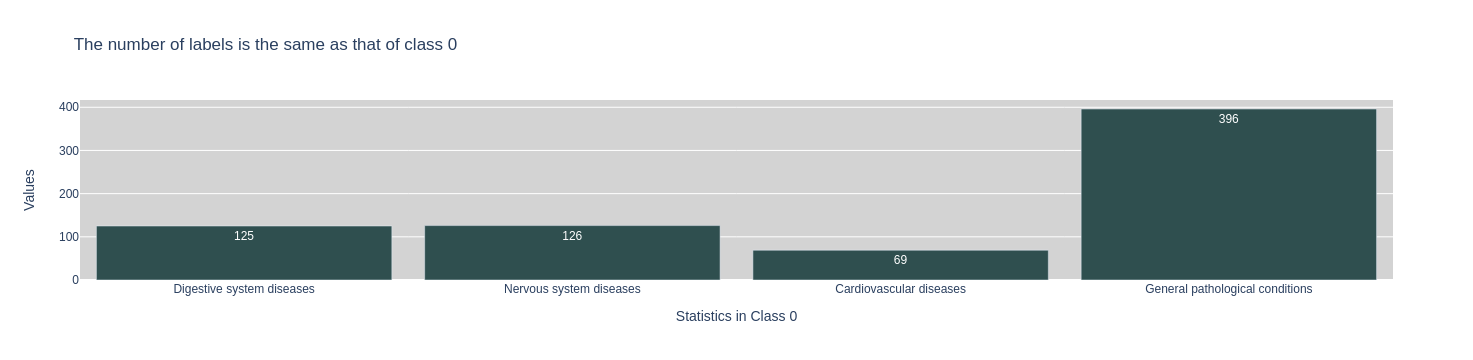

In [34]:
# Show the number of duplicate data of Class 0 compared to the remaining classes

labels = list(class_mapping.values())
labels.remove(labels[0])
values = [len(a_id_df_class_1), len(a_id_df_class_2), len(a_id_df_class_3), len(a_id_df_class_4)]

visualize_multilabel(labels,
                     values,
                     title='The number of labels is the same as that of class 0',
                     x_title='Statistics in Class 0'
                    )

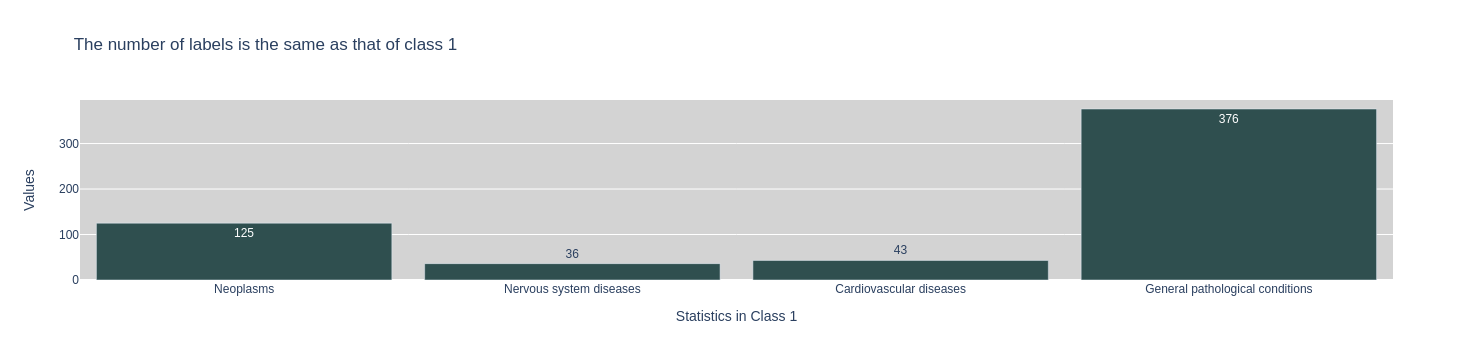

In [35]:
# Show the number of duplicate data of Class 1 compared to the remaining classes

labels = list(class_mapping.values())
labels.remove(labels[1])
values = [len(a_id_df_class_0_1), len(b_id_df_class_2), len(b_id_df_class_3), len(b_id_df_class_4)]

visualize_multilabel(labels,
                     values,
                     title='The number of labels is the same as that of class 1',
                     x_title='Statistics in Class 1'
                    )

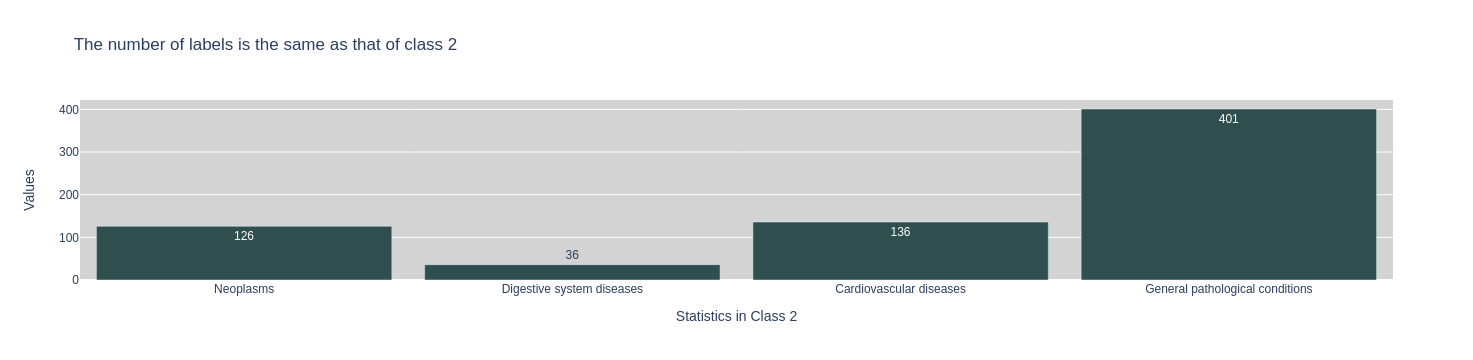

In [36]:
# Show the number of duplicate data of Class 2 compared to the remaining classes

labels = list(class_mapping.values())
labels.remove(labels[2])
values = [len(a_id_df_class_0_2), len(b_id_df_class_1_1), len(c_id_df_class_3), len(c_id_df_class_4)]

visualize_multilabel(labels,
                     values,
                     title='The number of labels is the same as that of class 2',
                     x_title='Statistics in Class 2'
                    )

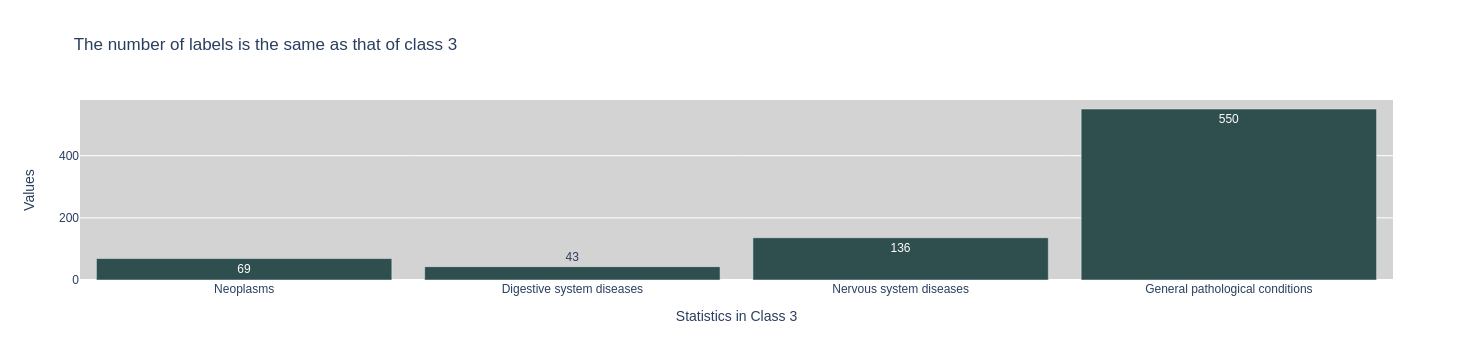

In [37]:
# Show the number of duplicate data of Class 3 compared to the remaining classes

labels = list(class_mapping.values())
labels.remove(labels[3])
values = [len(a_id_df_class_0_3), len(b_id_df_class_1_2), len(c_id_df_class_2_1), len(d_id_df_class_4)]

visualize_multilabel(labels,
                     values,
                     title='The number of labels is the same as that of class 3',
                     x_title='Statistics in Class 3'
                    )

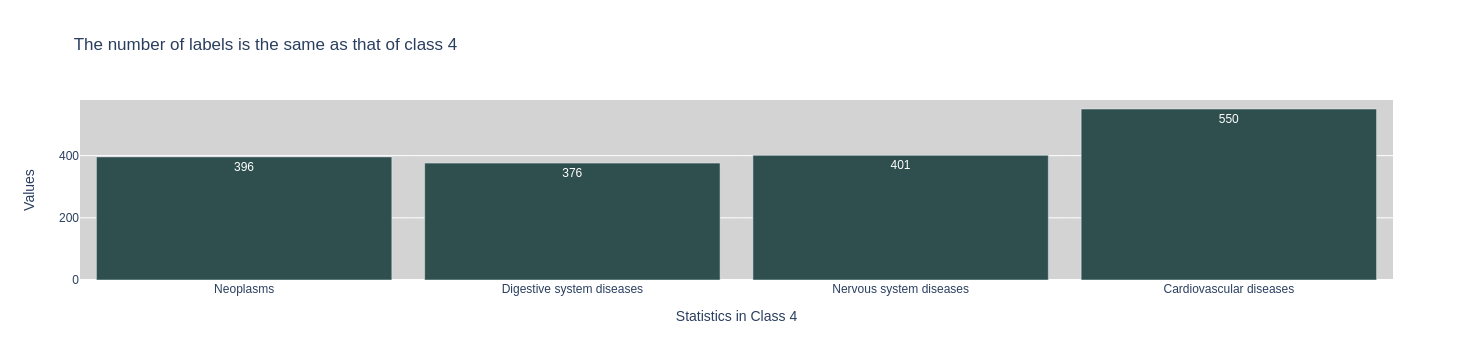

In [38]:
# Show the number of duplicate data of Class 4 compared to the remaining classes

labels = list(class_mapping.values())
labels.remove(labels[4])
values = [len(a_id_df_class_0_4), len(b_id_df_class_1_3), len(c_id_df_class_2_2), len(d_id_df_class_3_1)]

visualize_multilabel(labels,
                     values,
                     title='The number of labels is the same as that of class 4',
                     x_title='Statistics in Class 4'
                    )

In [39]:
# Filter out unique indexes that are multi-label data.

rep_df_class_0 = df_class_0.iloc[np.unique(total_id0)]
rep_df_class_1 = df_class_1.iloc[np.unique(total_id1)]
rep_df_class_2 = df_class_2.iloc[np.unique(total_id2)]
rep_df_class_3 = df_class_3.iloc[np.unique(total_id3)]

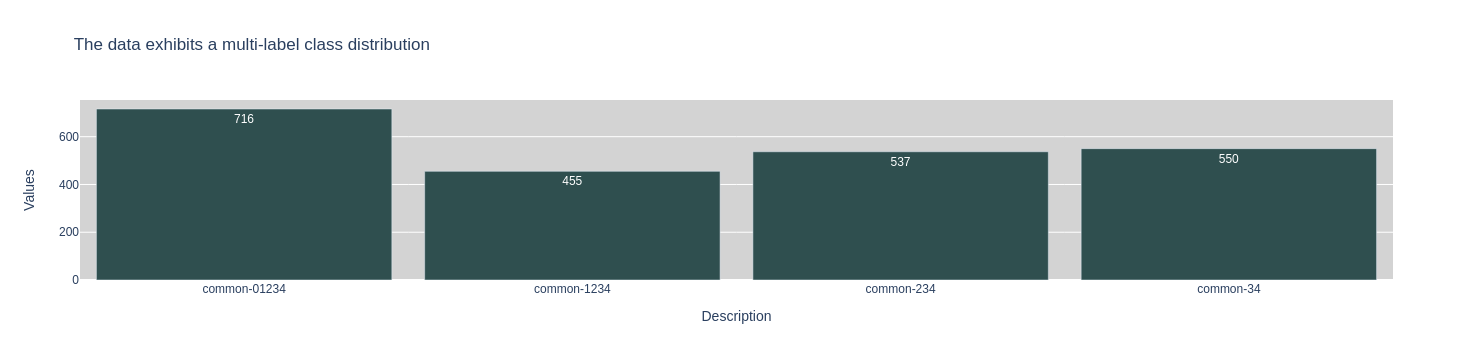

In [40]:
# Displays data in groups of overlapping data and is multi-labeled

labels = ['common-01234', 'common-1234', 'common-234', 'common-34']
values = [len(total_id0), len(total_id1), len(total_id2), len(total_id3)]
title='The data exhibits a multi-label class distribution'

visualize_multilabel(labels, values, title=title)

In [41]:
# Create rep_df include all of multi-labeled

rep_df = pd.concat([rep_df_class_0, rep_df_class_1, rep_df_class_2, rep_df_class_3], ignore_index=True)
rep_df = rep_df[['medical_abstract']]
rep_df.shape

(2105, 1)

### Note
- After calculating the Jaccard Score and observing that there is similarity in the quantity of duplicates analyzed above, precisely 2105 values</br>
it is evident that these text values contain at least 2 labels.
This aligns with the concept of 'multi-label,' which is commonly encountered in practical scenarios.

- To handle multi-label scenarios, a method is applied as described below.

In [42]:
rep_df.drop_duplicates(inplace=True)
rep_df.head()

medical_abstract
0  Lipolytic factors associated with murine and h...
1  Dilatation in the duplex kidney: 3 unusual cas...
2  Observations on the pathophysiology of Nelson'...
3  Angiotropic intravascular large-cell lymphoma ...
4  Soluble histocompatibility antigen class I in ...

In [43]:
rep_df.shape

(1956, 1)

* _The number of duplicated values matches the number of values after calculating the Jaccard Score. There are no other exceptional cases that would affect the analysis results regarding multi-label values in this scenario._

## Label encoding

#### Now perform an iteration and search for all labels of rep_df, then create a new column named 'condition_label_encode'.

In [44]:
check_list = rep_df['medical_abstract'].tolist()
f=0
values_lbl = []
for i in range(df.shape[0]):
    text = df['medical_abstract'].iloc[i]
    is_present = text in check_list
    if is_present:
        selected_df = df[df['medical_abstract']==text].condition_label.tolist()
    else:
        selected_df = [df.condition_label.iloc[i].tolist()]
    values_lbl.append(selected_df)

df['category_condition_label'] = values_lbl
df.head()

condition_label                                   medical_abstract  \
0                4  Tissue changes around loose prostheses. A cani...   
1                0  Neuropeptide Y and neuron-specific enolase lev...   
2                1  Sexually transmitted diseases of the colon, re...   
3                0  Lipolytic factors associated with murine and h...   
4                2  Does carotid restenosis predict an increased r...   

  category_condition_label  
0                      [4]  
1                      [0]  
2                      [1]  
3                   [0, 4]  
4                [2, 3, 4]

In [45]:
### Convert condition_label to binary with multi-label

df['binary_condition_label'] = df.category_condition_label.apply(lambda x: binary_cvt(x))
df.head()

condition_label                                   medical_abstract  \
0                4  Tissue changes around loose prostheses. A cani...   
1                0  Neuropeptide Y and neuron-specific enolase lev...   
2                1  Sexually transmitted diseases of the colon, re...   
3                0  Lipolytic factors associated with murine and h...   
4                2  Does carotid restenosis predict an increased r...   

  category_condition_label binary_condition_label  
0                      [4]        [0, 0, 0, 0, 1]  
1                      [0]        [1, 0, 0, 0, 0]  
2                      [1]        [0, 1, 0, 0, 0]  
3                   [0, 4]        [1, 0, 0, 0, 1]  
4                [2, 3, 4]        [0, 0, 1, 1, 1]

### Data processing
* Handling Text with Multi-label. Converting to One-Hot Encoding</br>
___Example: For multi-label data such as [0, 3] (out of a total of 5 classes), it will be encoded as [1, 0, 0, 1, 0].___
* In medical datasets, specific unit symbols and special characters are crucial for predicting disease stage and condition.</br>
* However, they may not be necessary for disease group classification.</br>
* Therefore, preprocessing will remove some less important characters such as: [ $, !, ?, (, ), [, ], ", ', =, :, `] and lowercase all text.
* I focus on retaining certain special symbols and medical abbreviations, such as '&', positive sign ('+'), negative sign ('-'), molecule, atom, 'Ca+' (calcium ion), 'K+' (potassium ion), within the healthcare domain.

#### Special Charecters

In [46]:
# Count total words in medical_abstract column
df['word_count'] = df.medical_abstract.apply(lambda x: len(x.strip().split()))

In [47]:
df.head()

condition_label                                   medical_abstract  \
0                4  Tissue changes around loose prostheses. A cani...   
1                0  Neuropeptide Y and neuron-specific enolase lev...   
2                1  Sexually transmitted diseases of the colon, re...   
3                0  Lipolytic factors associated with murine and h...   
4                2  Does carotid restenosis predict an increased r...   

  category_condition_label binary_condition_label  word_count  
0                      [4]        [0, 0, 0, 0, 1]         156  
1                      [0]        [1, 0, 0, 0, 0]         187  
2                      [1]        [0, 1, 0, 0, 0]         256  
3                   [0, 4]        [1, 0, 0, 0, 1]         146  
4                [2, 3, 4]        [0, 0, 1, 1, 1]         233

In [48]:
# Find and remove some special characters.

df = normalize_special_text(df, 'medical_abstract', 'normalize_medical_abstract')
df.head()

condition_label                                   medical_abstract  \
0                4  Tissue changes around loose prostheses. A cani...   
1                0  Neuropeptide Y and neuron-specific enolase lev...   
2                1  Sexually transmitted diseases of the colon, re...   
3                0  Lipolytic factors associated with murine and h...   
4                2  Does carotid restenosis predict an increased r...   

  category_condition_label binary_condition_label  word_count  \
0                      [4]        [0, 0, 0, 0, 1]         156   
1                      [0]        [1, 0, 0, 0, 0]         187   
2                      [1]        [0, 1, 0, 0, 0]         256   
3                   [0, 4]        [1, 0, 0, 0, 1]         146   
4                [2, 3, 4]        [0, 0, 1, 1, 1]         233   

                          normalize_medical_abstract  
0  Tissue changes around loose prostheses A canin...  
1  Neuropeptide Y and neuron-specific enolase lev...  
2  Sexually transmitted diseases of the colon rec...  
3  Lipolytic factors associated with murine and h...  
4  Does carotid restenosis predict an increased r...

#### Remove Stop Words

* In general text classification tasks, including medical text classification,
* stop words such as [the, and, a, an, ...] are typically considered to have little value in improving accuracy.
* On the contrary, keeping these stop words increases the number of tokens while reducing the information conveyed by specialized terms.

In [49]:
df = remove_stopwords(df, 'normalize_medical_abstract')
df.head()

condition_label                                   medical_abstract  \
0                4  Tissue changes around loose prostheses. A cani...   
1                0  Neuropeptide Y and neuron-specific enolase lev...   
2                1  Sexually transmitted diseases of the colon, re...   
3                0  Lipolytic factors associated with murine and h...   
4                2  Does carotid restenosis predict an increased r...   

  category_condition_label binary_condition_label  word_count  \
0                      [4]        [0, 0, 0, 0, 1]         156   
1                      [0]        [1, 0, 0, 0, 0]         187   
2                      [1]        [0, 1, 0, 0, 0]         256   
3                   [0, 4]        [1, 0, 0, 0, 1]         146   
4                [2, 3, 4]        [0, 0, 1, 1, 1]         233   

                          normalize_medical_abstract  
0  Tissue changes around loose prostheses canine ...  
1  Neuropeptide Y neuron-specific enolase levels ...  
2  Sexually transmitted diseases colon rectum anu...  
3  Lipolytic factors associated murine human canc...  
4  carotid restenosis predict increased risk late...

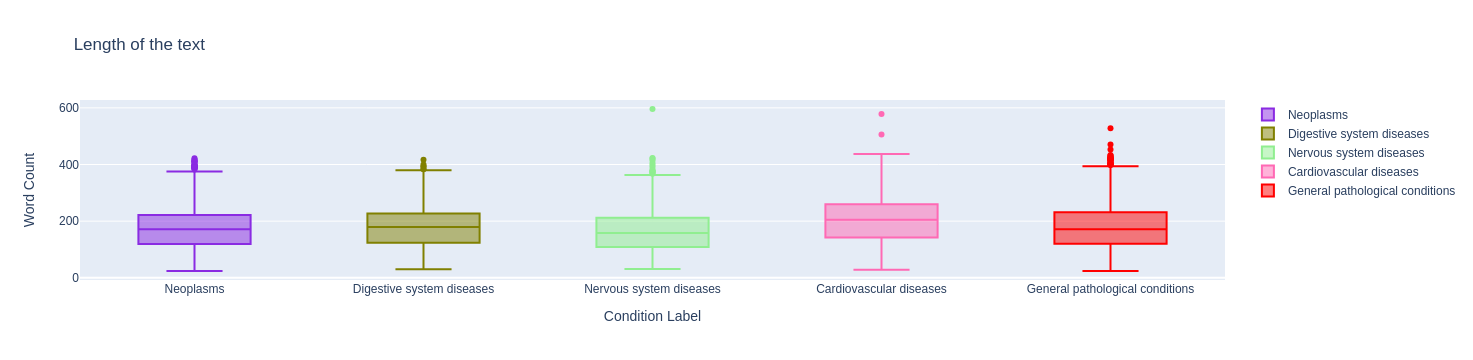

In [50]:
get_quartile_range(df, 'word_count', [0,1,2,3,4])

__Preliminary observations of the quartile summary for neoplasms reveal the following:__
* For neoplasms: min=24, 25th=119, 50th=171, 75th=222, upper-fence=375, max=422
* For digestive system diseases: min=30, 25th=124, 50th=179, 75th=227, upper-fence=380, max=417
* For nervous system diseases: min=31, 25th=109, 50th=158, 75th=212, upper-fence=363, max=596
* For cardiovascular diseases: min=28, 25th=142, 50th=205, 75th=260, upper-fence=437, max=578
* For general pathological conditions: min=24, 25th=120, 50th=171, 75th=231, upper-fence=394, max=528
```
When using a max-token of 512 for BERT base and some other variants, there are instances where outliers exceed this max-token value.
```

#### Vocabulary analysis

__Analyzing the number of vocabulary can show:__
* range of word count distribution
* Number of vocabulary each class possesses
* Frequency of words used in each class
* The degree of relatedness of vocabulary between classes

In [51]:
# Counting the number of words in each row

In [52]:
df['normalize_word_count'] = df.normalize_medical_abstract.apply(lambda x: len(x.strip().split()))
df.head()

condition_label                                   medical_abstract  \
0                4  Tissue changes around loose prostheses. A cani...   
1                0  Neuropeptide Y and neuron-specific enolase lev...   
2                1  Sexually transmitted diseases of the colon, re...   
3                0  Lipolytic factors associated with murine and h...   
4                2  Does carotid restenosis predict an increased r...   

  category_condition_label binary_condition_label  word_count  \
0                      [4]        [0, 0, 0, 0, 1]         156   
1                      [0]        [1, 0, 0, 0, 0]         187   
2                      [1]        [0, 1, 0, 0, 0]         256   
3                   [0, 4]        [1, 0, 0, 0, 1]         146   
4                [2, 3, 4]        [0, 0, 1, 1, 1]         233   

                          normalize_medical_abstract  normalize_word_count  
0  Tissue changes around loose prostheses canine ...                    91  
1  Neuropeptide Y neuron-specific enolase levels ...                   112  
2  Sexually transmitted diseases colon rectum anu...                   157  
3  Lipolytic factors associated murine human canc...                    96  
4  carotid restenosis predict increased risk late...                   152

In [53]:
# Show the barplot to see overview of Vocabulary of Frequency

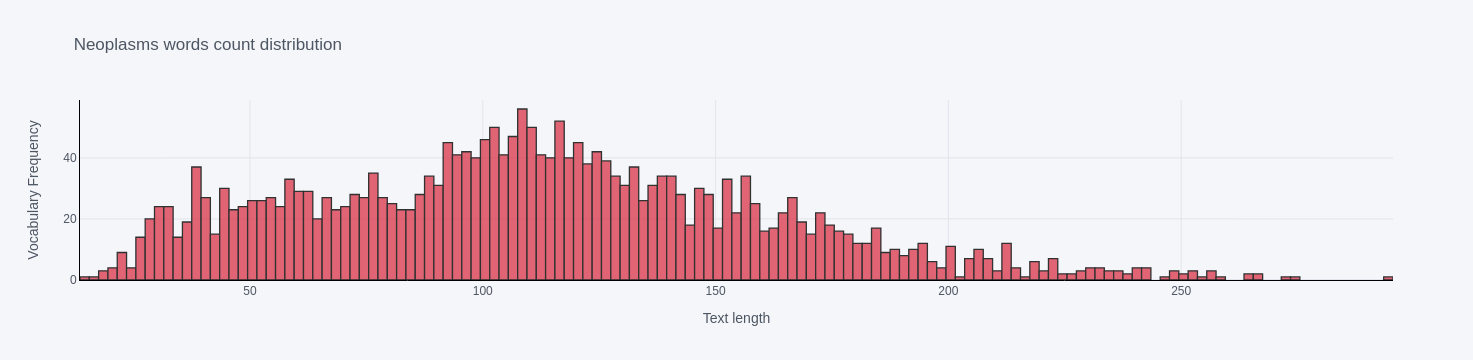

Max word count for Neoplasms: 294
Min word count for Neoplasms: 14


In [54]:
show_wordCount(df, 'normalize_word_count', 0, 'Neoplasms')

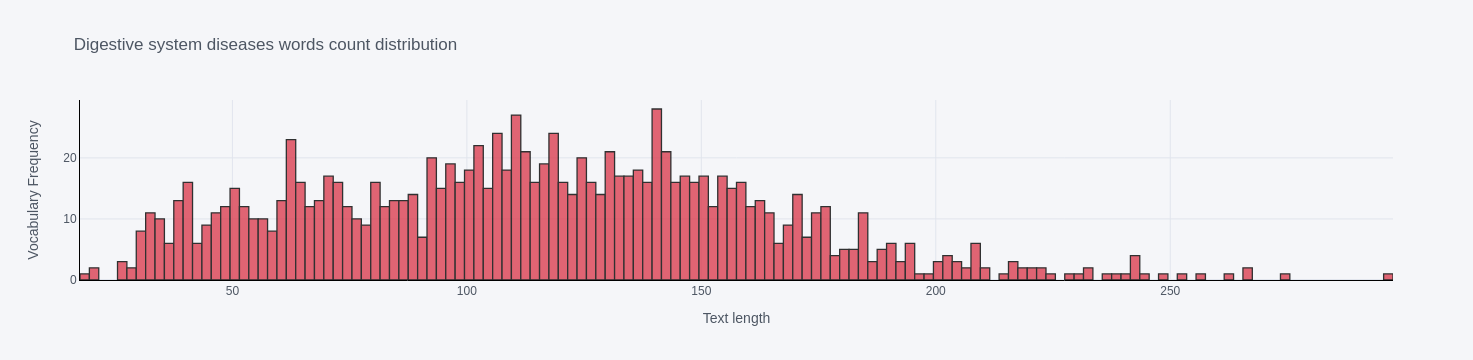

Max word count for Digestive system diseases: 296
Min word count for Digestive system diseases: 18


In [55]:
show_wordCount(df, 'normalize_word_count', 1, 'Digestive system diseases')

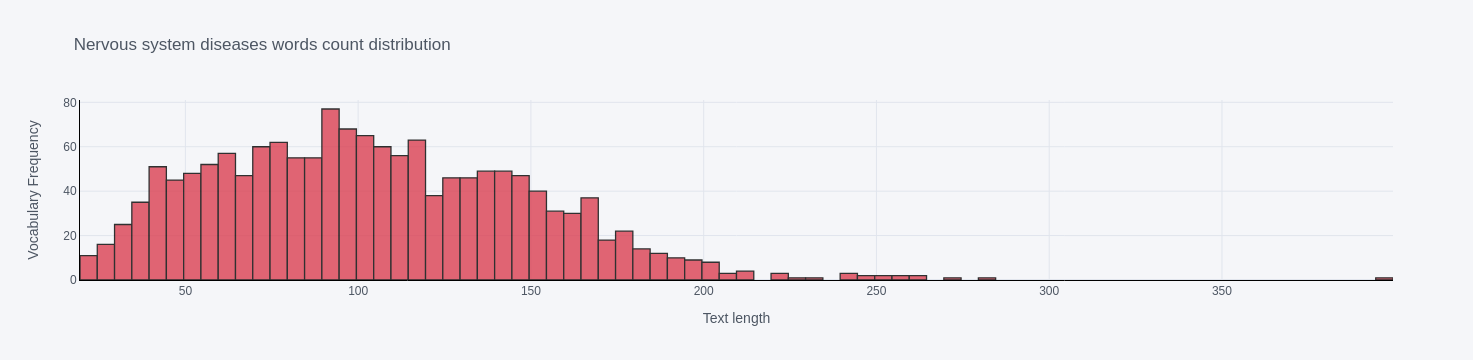

Max word count for Nervous system diseases: 398
Min word count for Nervous system diseases: 20


In [56]:
show_wordCount(df, 'normalize_word_count', 2, 'Nervous system diseases')

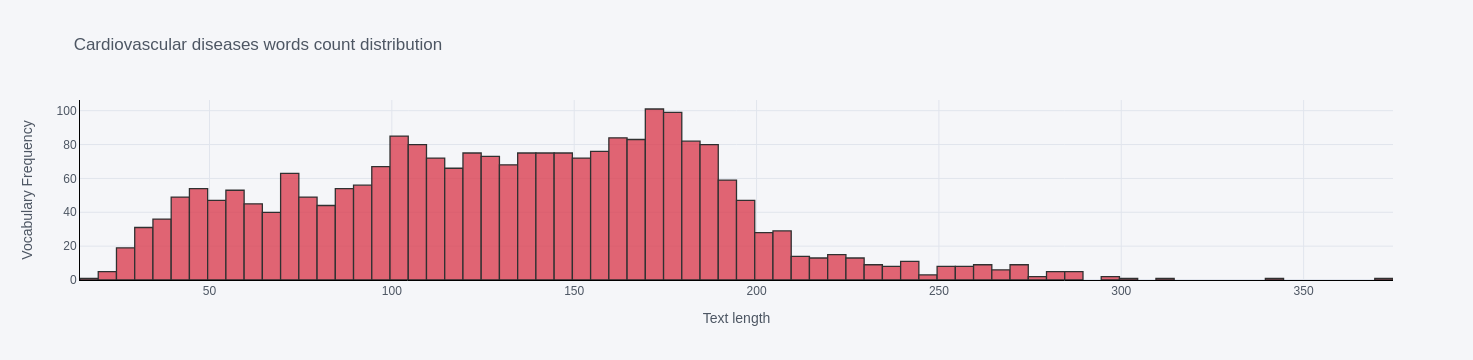

Max word count for Cardiovascular diseases: 370
Min word count for Cardiovascular diseases: 18


In [57]:
show_wordCount(df, 'normalize_word_count', 3, 'Cardiovascular diseases')

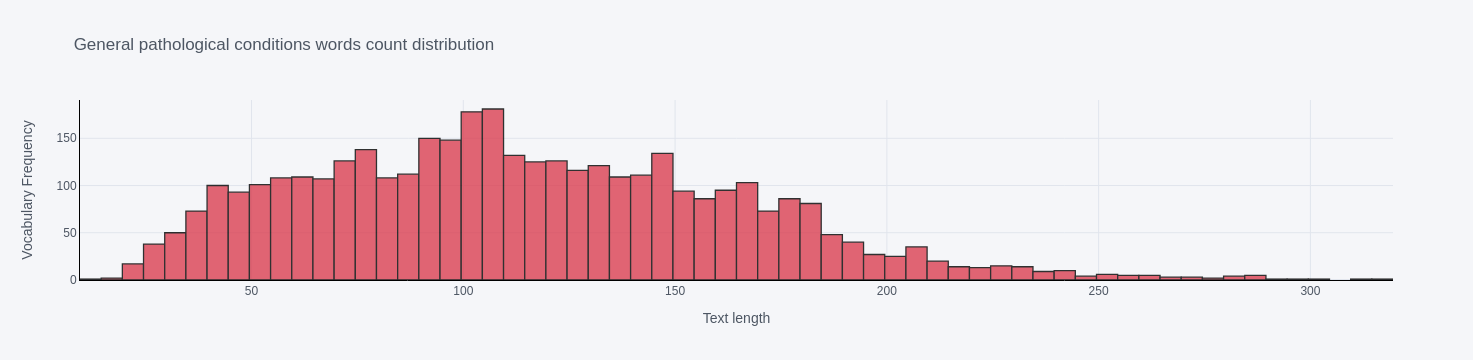

Max word count for General pathological conditions: 319
Min word count for General pathological conditions: 14


In [58]:
show_wordCount(df, 'normalize_word_count', 4, 'General pathological conditions')

* Analyzing the number of words in sentences for each disease group to determine the maximum number of tokens when initializing the model</br>
_The specific charts above show the distribution of the number of words for each class as follows:_ </br>
&emsp; ***Class 0-Neoplasms***: The distribution of data with the most common frequency is between 30-173 words. **The highest is 294 and the lowest is 14.**</br>
&emsp; ***Class 1-Digestive system diseases***: The distribution of data with the most common frequency is between 44-174 words. **The highest is 296 and the lowest is 18.**</br>
&emsp; ***Class 2-Nervous system diseases***: The distribution of data with the most common frequency is between 30-169 words. **The highest is 398 and the lowest is 20.**</br>
&emsp; ***Class 3-Cardiovascular diseases***: The distribution of data with the most common frequency is between 35-199 words. **The highest is 370 and the lowest is 18.**</br>
&emsp; ***Class 4-general pathological conditions***: The distribution of data with the most common frequency is between 40-184 words. **The highest is 319 and the lowest is 14.**

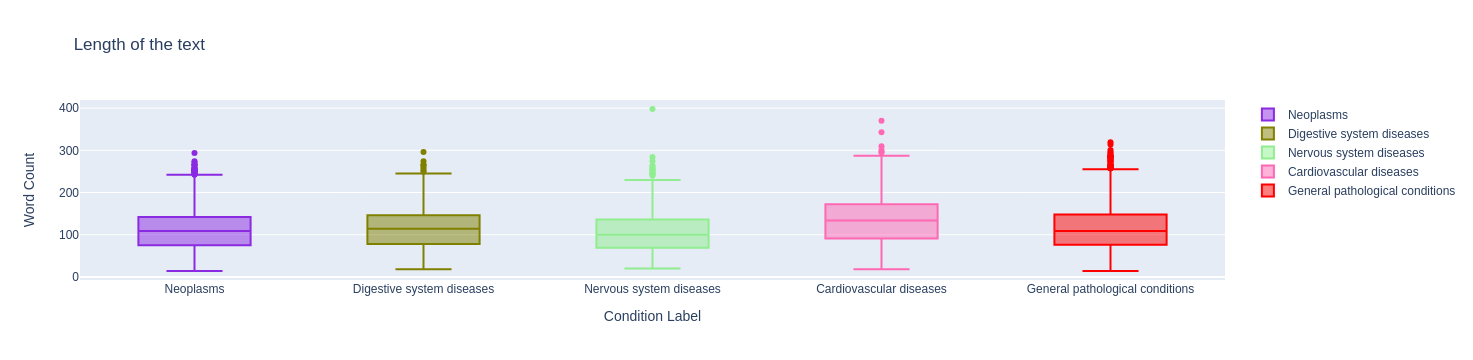

In [59]:
get_quartile_range(df, 'normalize_word_count', [0,1,2,3,4])

```
* Based on the quartile plots, it canBased on the quartile plots,
  it can be observed that the medians of the classes are very close to each other,
  ranging from 104 to 135. This indicates that the data in each class is relatively evenly distributed.
* The 25th-75th percentiles of the 4 classes also do not have a large difference be observed that the medians of the classes are very close to each other [69-172].
* The 25th-75th percentiles of the 4 classes do not have a large difference.
```

In [60]:
df.head()

condition_label                                   medical_abstract  \
0                4  Tissue changes around loose prostheses. A cani...   
1                0  Neuropeptide Y and neuron-specific enolase lev...   
2                1  Sexually transmitted diseases of the colon, re...   
3                0  Lipolytic factors associated with murine and h...   
4                2  Does carotid restenosis predict an increased r...   

  category_condition_label binary_condition_label  word_count  \
0                      [4]        [0, 0, 0, 0, 1]         156   
1                      [0]        [1, 0, 0, 0, 0]         187   
2                      [1]        [0, 1, 0, 0, 0]         256   
3                   [0, 4]        [1, 0, 0, 0, 1]         146   
4                [2, 3, 4]        [0, 0, 1, 1, 1]         233   

                          normalize_medical_abstract  normalize_word_count  
0  Tissue changes around loose prostheses canine ...                    91  
1  Neuropeptide Y neuron-specific enolase levels ...                   112  
2  Sexually transmitted diseases colon rectum anu...                   157  
3  Lipolytic factors associated murine human canc...                    96  
4  carotid restenosis predict increased risk late...                   152

#### Visualizer for the top 20 most frequently occurring words of each class.

In [61]:
top_0 = get_top_n_words(df[df.condition_label==0], cols='normalize_medical_abstract', n=50)

In [62]:
top_1 = get_top_n_words(df[df.condition_label==1], cols='normalize_medical_abstract', n=50)

In [63]:
top_2 = get_top_n_words(df[df.condition_label==2], cols='normalize_medical_abstract', n=50)

In [64]:
top_3 = get_top_n_words(df[df.condition_label==3], cols='normalize_medical_abstract', n=50)

In [65]:
top_4 = get_top_n_words(df[df.condition_label==4], cols='normalize_medical_abstract', n=50)

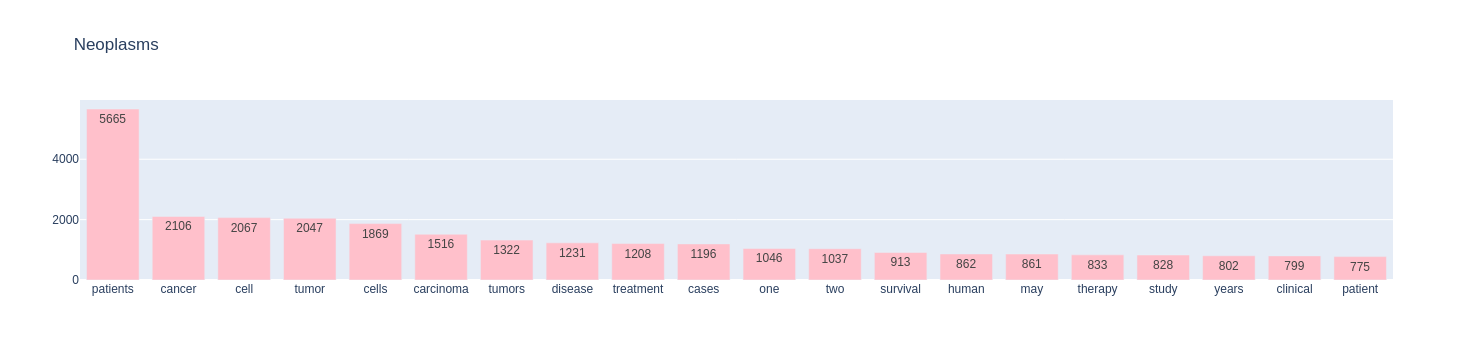

In [66]:
words, frequencies = zip(*top_0)
fig = visualization_top_word_count(words, frequencies, frequencies, title='Neoplasms', color='pink', top_n=20)
fig.show()

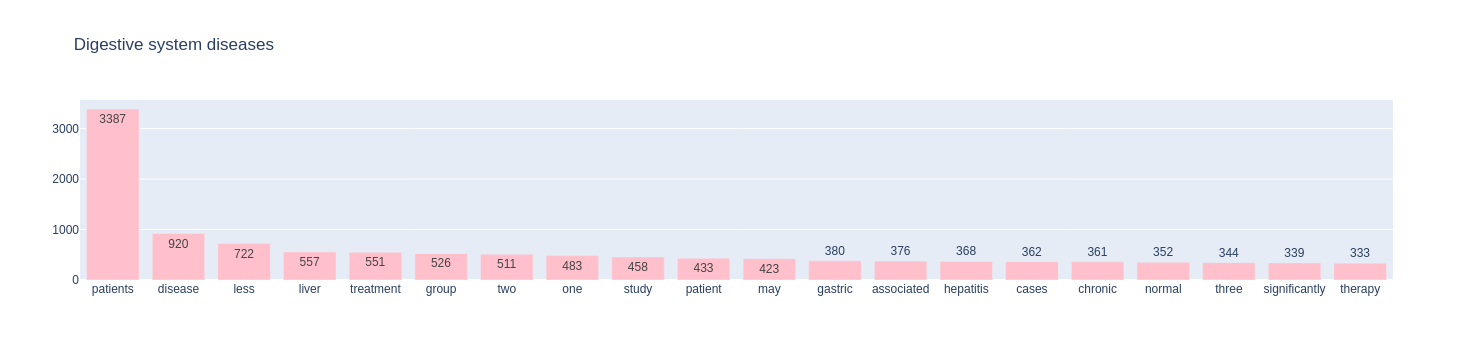

In [67]:
words, frequencies = zip(*top_1)
fig = visualization_top_word_count(words, frequencies, frequencies, title='Digestive system diseases', color='pink', top_n=20)
fig.show()

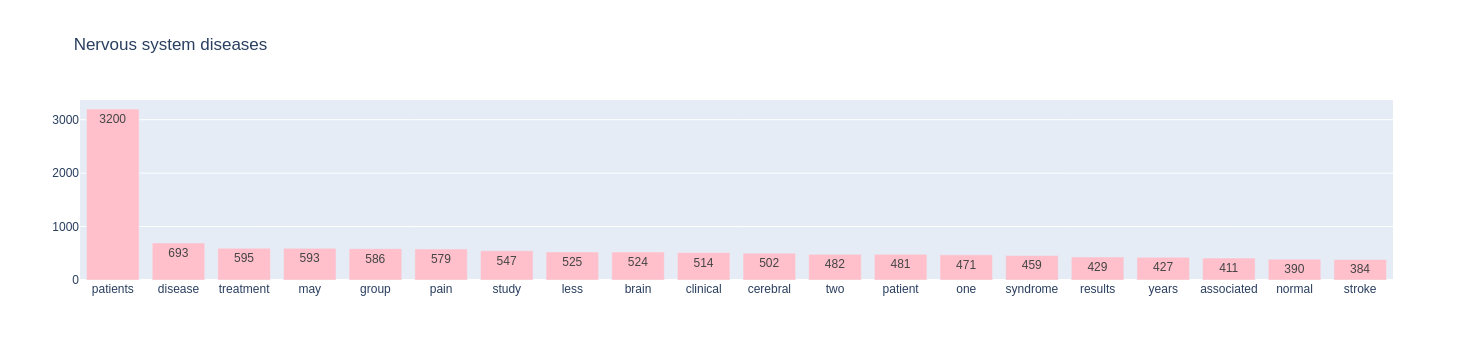

In [68]:
words, frequencies = zip(*top_2)
fig = visualization_top_word_count(words, frequencies, frequencies, title='Nervous system diseases', color='pink', top_n=20)
fig.show()

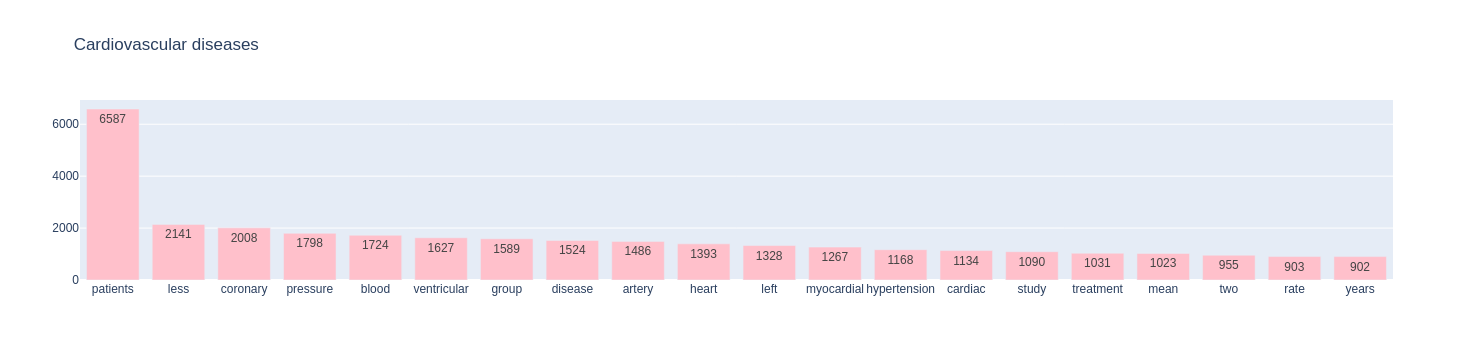

In [69]:
words, frequencies = zip(*top_3)
fig = visualization_top_word_count(words, frequencies, frequencies, title='Cardiovascular diseases', color='pink', top_n=20)
fig.show()

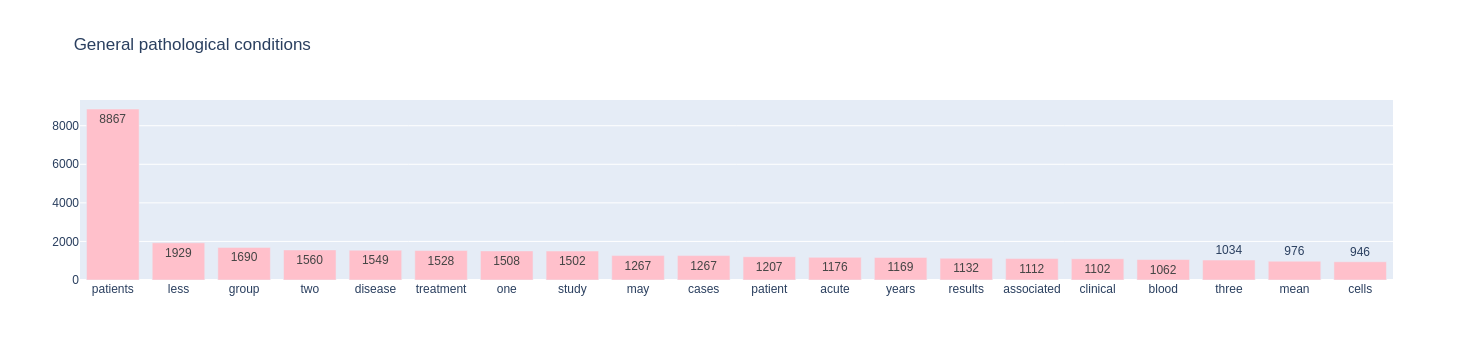

In [70]:
words, frequencies = zip(*top_4)
fig = visualization_top_word_count(words, frequencies, frequencies, title='General pathological conditions', color='pink', top_n=20)
fig.show()

* There is a peculiar aspect where words such as 'patients' and 'patient' (along with many others) both refer to a group of individuals but are considered as distinct words. 
* The major distinction lies in how sentences are structured in singular or plural form, and this could potentially impact text classification if not normalized to the base form 'patient'.

### Stemming and Lemmatization

In [71]:
# Apply stemming to the 'normalize_medical_abstract' column and create a new column
# 'stemming_normalize_medical_abstract' containing the preprocessed text with stemming.
df['stemming_normalize_medical_abstract'] = df['normalize_medical_abstract'].apply(lambda x: stemming_lemma_reprocess(x, type_select='stemming'))

# Apply lemmatization to the 'normalize_medical_abstract' column and create a new column
# 'lemma_normalize_medical_abstract' containing the preprocessed text with lemmatization.
df['lemma_normalize_medical_abstract'] = df['normalize_medical_abstract'].apply(lambda x: stemming_lemma_reprocess(x, type_select='lemma'))

df.head()

condition_label                                   medical_abstract  \
0                4  Tissue changes around loose prostheses. A cani...   
1                0  Neuropeptide Y and neuron-specific enolase lev...   
2                1  Sexually transmitted diseases of the colon, re...   
3                0  Lipolytic factors associated with murine and h...   
4                2  Does carotid restenosis predict an increased r...   

  category_condition_label binary_condition_label  word_count  \
0                      [4]        [0, 0, 0, 0, 1]         156   
1                      [0]        [1, 0, 0, 0, 0]         187   
2                      [1]        [0, 1, 0, 0, 0]         256   
3                   [0, 4]        [1, 0, 0, 0, 1]         146   
4                [2, 3, 4]        [0, 0, 1, 1, 1]         233   

                          normalize_medical_abstract  normalize_word_count  \
0  Tissue changes around loose prostheses canine ...                    91   
1  Neuropeptide Y neuron-specific enolase levels ...                   112   
2  Sexually transmitted diseases colon rectum anu...                   157   
3  Lipolytic factors associated murine human canc...                    96   
4  carotid restenosis predict increased risk late...                   152   

                 stemming_normalize_medical_abstract  \
0  tissu chang around loos prosthes canin model i...   
1  neuropeptid y neuron-specif enolas level benig...   
2  sexual transmit diseas colon rectum anu challe...   
3  lipolyt factor associ murin human cancer cache...   
4  carotid restenosi predict increas risk late sy...   

                    lemma_normalize_medical_abstract  
0  Tissue change around loose prosthesis canine m...  
1  Neuropeptide Y neuron-specific enolase level b...  
2  Sexually transmitted disease colon rectum anus...  
3  Lipolytic factor associated murine human cance...  
4  carotid restenosis predict increased risk late...

In [72]:
# Show text after processed with Stemming
df.stemming_normalize_medical_abstract.iloc[10]

'sodium sensit sodium retain hypertens differ sodium sensit sodium retain hypertens theoret consid use water tank model bodi fluid volume-blood pressur regul outlet valv attach tank base area correspond reciproc total peripher resist tpr water pour tank rate correspond amount na+ intak equilibrium achiev certain water level volum output outlet repres mean arteri pressur map cardiac output co urinari na+ excret height outlet tank bottom size cross-sect area outlet correspond x-intercept slope renal function pressure-natriuresi curv respect nonsodium sensit hypertens due shift curv toward higher blood pressur level elev height outlet without chang slope size outlet sodium sensit hypertens due depress slope curv reduc outlet size map water level also co water volum increas result sodium retain hypertens tpr reciproc base area remain unchang co rel unchang result nonsodium retain hypertens tpr elev thu map sensit sodium intak determin renal function curv sinc bodi fluid volum determin rena

In [73]:
# Show text after processed with Lemmatization
df.lemma_normalize_medical_abstract.iloc[10]

'Sodium sensitive sodium retaining hypertension difference sodium sensitive sodium retaining hypertension theoretically considered using water tank model body fluid volume-blood pressure regulation outlet valve attached tank base area corresponding reciprocal total peripheral resistance TPR water poured tank rate corresponding amount Na+ intake equilibrium achieved certain water level volume output outlet represent mean arterial pressure MAP cardiac output CO urinary Na+ excretion height outlet tank bottom size cross-sectional area outlet correspond x-intercept slope renal function pressure-natriuresis curve respectively nonsodium sensitive hypertension due shift curve toward higher blood pressure level elevated height outlet without change slope size outlet sodium sensitive hypertension due depressed slope curve reduced outlet size MAP water level also CO water volume increased resulting sodium retaining hypertension TPR reciprocal base area remained unchanged CO relatively unchanged 

#### Preliminary vision
* We can observe that the Lemmatizer performs more accurately based on the text processing requirements, although pre-trained BERT models trained on medical text data can also handle the diverse language. 
* However, the Lemmatizer helps simplify the vocabulary without cutting or truncating words, as in the case of Stemming.
* The result of stemming returns data in lowercase, which inadvertently may not be compatible with some pre-trained BERT models that can operate on both uppercase and lowercase letters.

In [74]:
# Create lemmatization and stemming processing

In [75]:
top_0_lemma = get_top_n_words(df[df.condition_label==0], cols='lemma_normalize_medical_abstract', n=50)
top_0_stemming = get_top_n_words(df[df.condition_label==0], cols='stemming_normalize_medical_abstract', n=50)

In [76]:
top_1_lemma = get_top_n_words(df[df.condition_label==1], cols='lemma_normalize_medical_abstract', n=50)
top_1_stemming = get_top_n_words(df[df.condition_label==1], cols='stemming_normalize_medical_abstract', n=50)

In [77]:
top_2_lemma = get_top_n_words(df[df.condition_label==2], cols='lemma_normalize_medical_abstract', n=50)
top_2_stemming = get_top_n_words(df[df.condition_label==2], cols='stemming_normalize_medical_abstract', n=50)

In [78]:
top_3_lemma = get_top_n_words(df[df.condition_label==3], cols='lemma_normalize_medical_abstract', n=50)
top_3_stemming = get_top_n_words(df[df.condition_label==3], cols='stemming_normalize_medical_abstract', n=50)

In [79]:
top_4_lemma = get_top_n_words(df[df.condition_label==4], cols='lemma_normalize_medical_abstract', n=50)
top_4_stemming = get_top_n_words(df[df.condition_label==4], cols='stemming_normalize_medical_abstract', n=50)

In [80]:
# Show top words with Lemmatization

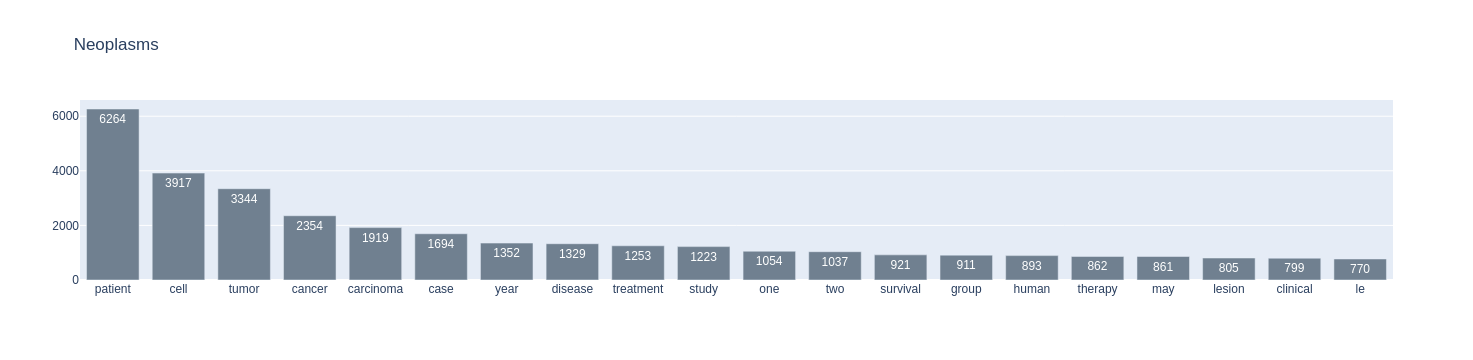

In [81]:
words, frequencies = zip(*top_0_lemma)
fig = visualization_top_word_count(words, frequencies, frequencies, title='Neoplasms', color='slategrey', top_n=20)
fig.show()

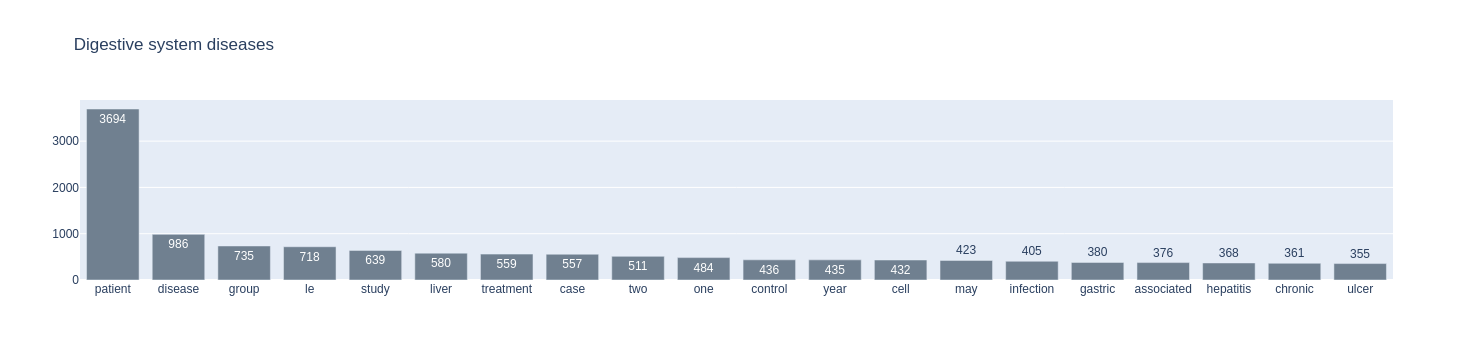

In [82]:
words, frequencies = zip(*top_1_lemma)
fig = visualization_top_word_count(words, frequencies, frequencies, title='Digestive system diseases', color='slategrey', top_n=20)
fig.show()

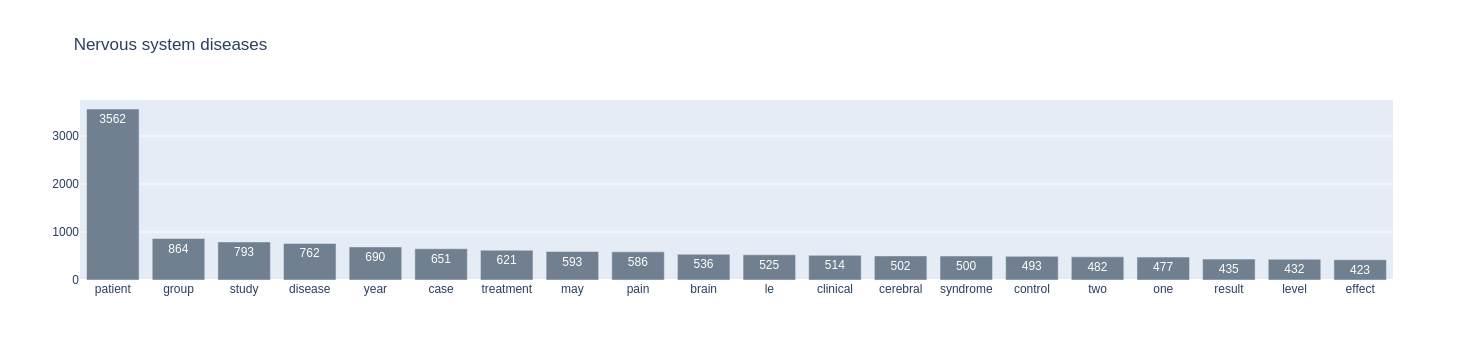

In [83]:
words, frequencies = zip(*top_2_lemma)
fig = visualization_top_word_count(words, frequencies, frequencies, title='Nervous system diseases', color='slategrey', top_n=20)
fig.show()

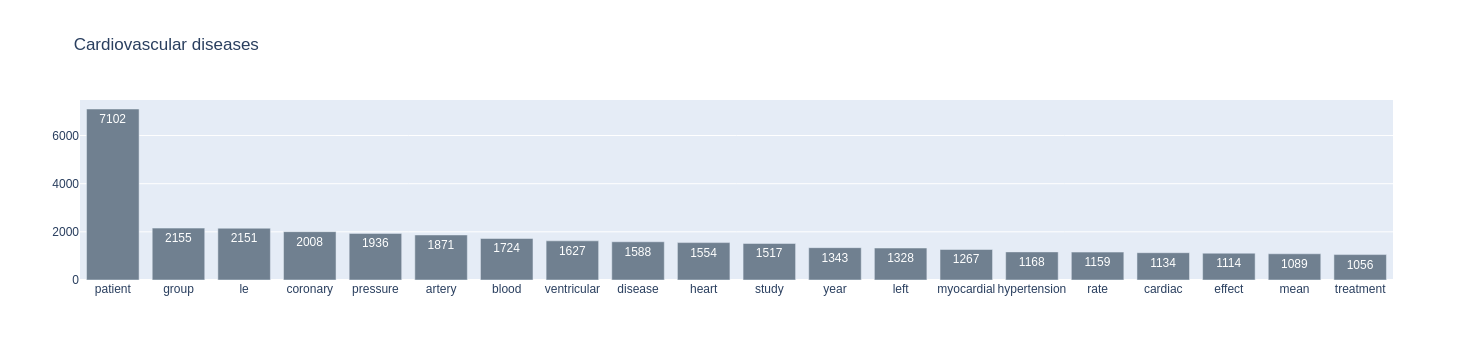

In [84]:
words, frequencies = zip(*top_3_lemma)
fig = visualization_top_word_count(words, frequencies, frequencies, title='Cardiovascular diseases', color='slategrey', top_n=20)
fig.show()

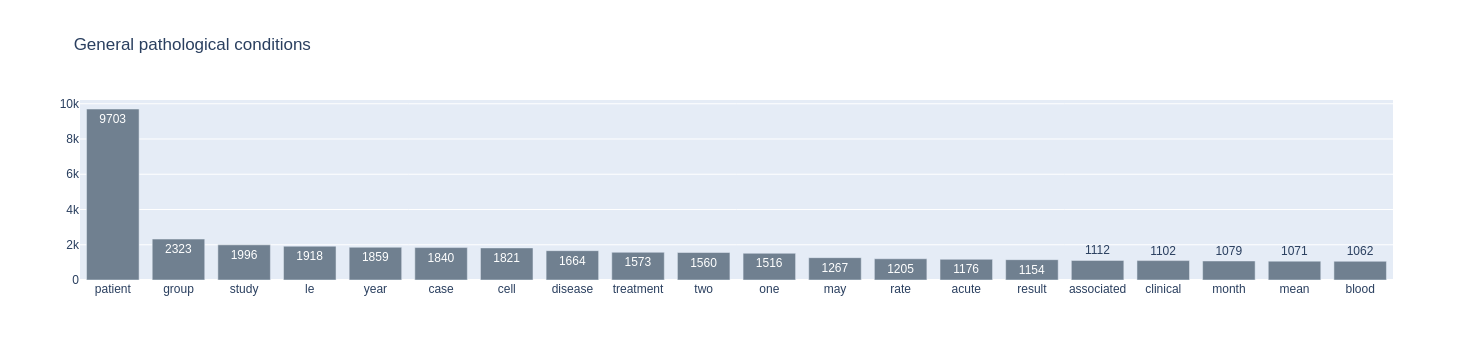

In [85]:
words, frequencies = zip(*top_4_lemma)
fig = visualization_top_word_count(words, frequencies, frequencies, title='General pathological conditions', color='slategrey', top_n=20)
fig.show()

* 'patients' and 'patient' have been standardized

In [86]:
# Show top words with Stemming

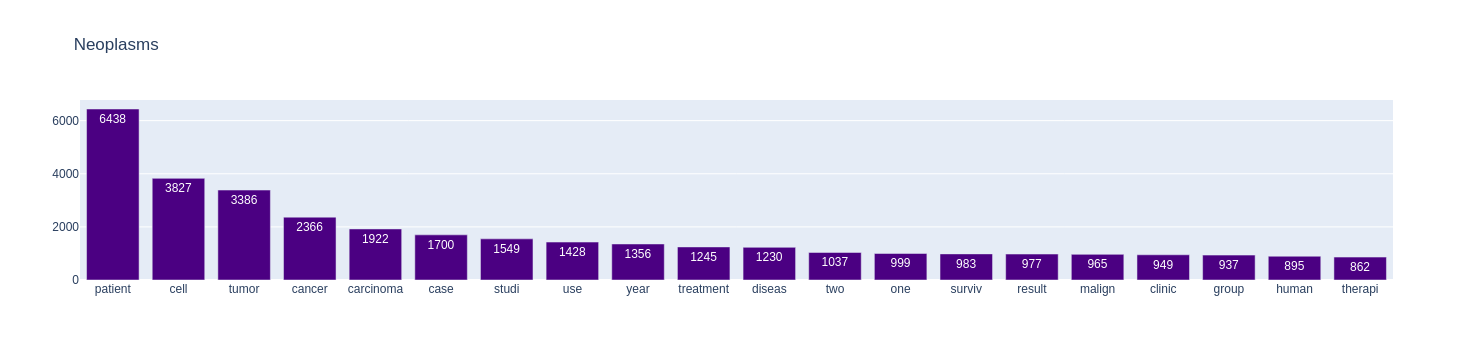

In [87]:
words, frequencies = zip(*top_0_stemming)
fig = visualization_top_word_count(words, frequencies, frequencies, title='Neoplasms', color='indigo', top_n=20)
fig.show()

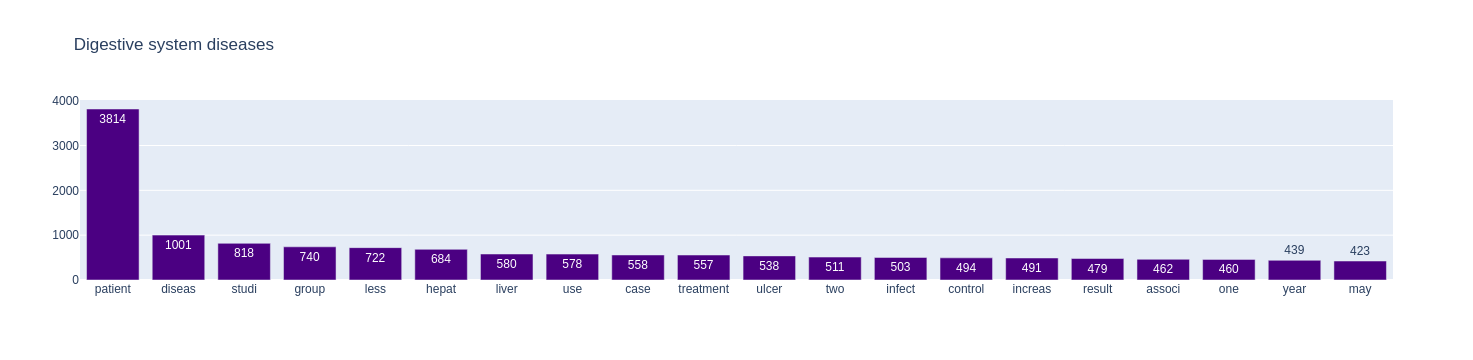

In [88]:
words, frequencies = zip(*top_1_stemming)
fig = visualization_top_word_count(words, frequencies, frequencies, title='Digestive system diseases', color='indigo', top_n=20)
fig.show()

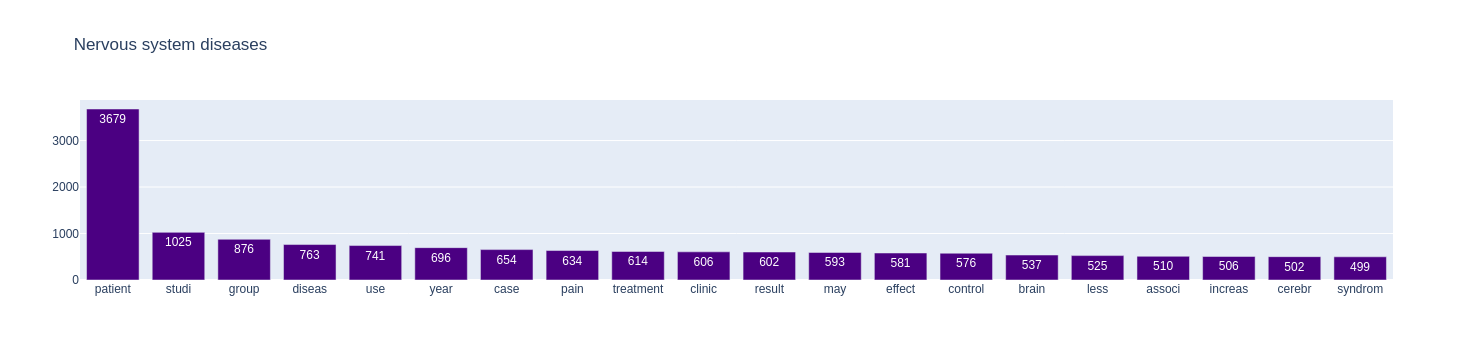

In [89]:
words, frequencies = zip(*top_2_stemming)
fig = visualization_top_word_count(words, frequencies, frequencies, title='Nervous system diseases', color='indigo', top_n=20)
fig.show()

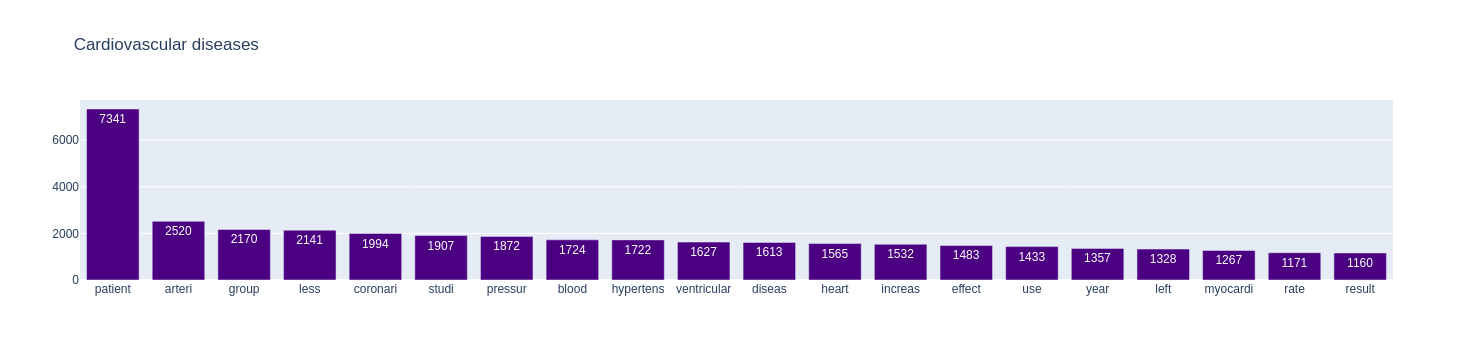

In [90]:
words, frequencies = zip(*top_3_stemming)
fig = visualization_top_word_count(words, frequencies, frequencies, title='Cardiovascular diseases', color='indigo', top_n=20)
fig.show()

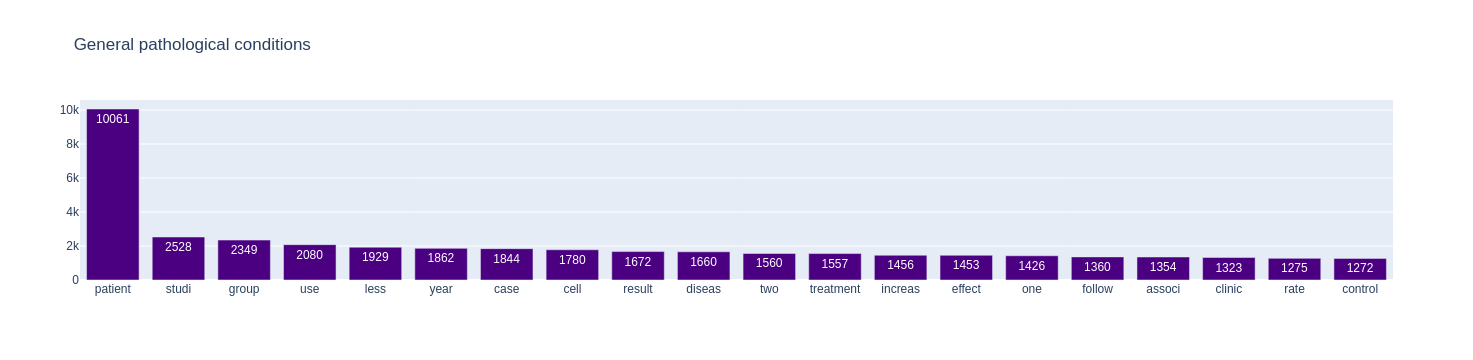

In [91]:
words, frequencies = zip(*top_4_stemming)
fig = visualization_top_word_count(words, frequencies, frequencies, title='General pathological conditions', color='indigo', top_n=20)
fig.show()

* __Take common words, evenly distributed in at least 3 classes and in the top 50 will be eliminated__

In [92]:
# Show total commond words on top 50
com_words = find_common_words([top_0, top_1, top_2, top_3, top_4])
len(com_words)

39

In [93]:
com_words

{'patients': '',
 'cells': '',
 'disease': '',
 'treatment': '',
 'cases': '',
 'one': '',
 'two': '',
 'may': '',
 'therapy': '',
 'study': '',
 'years': '',
 'clinical': '',
 'patient': '',
 'less': '',
 'three': '',
 'results': '',
 'months': '',
 'group': '',
 'treated': '',
 'found': '',
 'associated': '',
 'normal': '',
 '10': '',
 'high': '',
 'year': '',
 'risk': '',
 'also': '',
 'four': '',
 'rate': '',
 'significantly': '',
 'acute': '',
 'compared': '',
 'significant': '',
 'increased': '',
 'mean': '',
 'pain': '',
 'age': '',
 'control': '',
 'blood': ''}

In [94]:
# Show total commond words on top 50 with lemma
com_words_lemma = find_common_words([top_0_lemma, top_1_lemma, top_2_lemma, top_3_lemma, top_4_lemma])
len(com_words_lemma)

38

In [95]:
# Show first 20 words in com_words_lemma
limited_rare = {key for key in list(com_words_lemma)[:20]}
limited_rare

{'case',
 'cell',
 'clinical',
 'disease',
 'factor',
 'group',
 'le',
 'may',
 'month',
 'one',
 'patient',
 'rate',
 'result',
 'study',
 'therapy',
 'three',
 'treatment',
 'tumor',
 'two',
 'year'}

In [96]:
# Replace common words with empty at "normalize_medical_abstract" column.
df.normalize_medical_abstract = df.normalize_medical_abstract.apply(lambda x: replace_words(x, com_words))
df.normalize_word_count = df.normalize_medical_abstract.apply(lambda x: len(x.strip().split()))

In [97]:
# Replace common words with empty at "lemma_normalize_medical_abstract" column.
df.lemma_normalize_medical_abstract = df.lemma_normalize_medical_abstract.apply(lambda x: replace_words(x, com_words_lemma))

In [98]:
# Create column "lemma_word_count" to check quartile range
df['lemma_word_count'] = df.lemma_normalize_medical_abstract.apply(lambda x: len(x.strip().split()))

In [99]:
df.head()

condition_label                                   medical_abstract  \
0                4  Tissue changes around loose prostheses. A cani...   
1                0  Neuropeptide Y and neuron-specific enolase lev...   
2                1  Sexually transmitted diseases of the colon, re...   
3                0  Lipolytic factors associated with murine and h...   
4                2  Does carotid restenosis predict an increased r...   

  category_condition_label binary_condition_label  word_count  \
0                      [4]        [0, 0, 0, 0, 1]         156   
1                      [0]        [1, 0, 0, 0, 0]         187   
2                      [1]        [0, 1, 0, 0, 0]         256   
3                   [0, 4]        [1, 0, 0, 0, 1]         146   
4                [2, 3, 4]        [0, 0, 1, 1, 1]         233   

                          normalize_medical_abstract  normalize_word_count  \
0  Tissue changes around loose prostheses canine ...                    85   
1  Neuropeptide Y neuron-specific enolase levels ...                   100   
2  Sexually transmitted diseases colon rectum anu...                   137   
3  Lipolytic factors  murine human cancer cachexi...                    84   
4  carotid restenosis predict   late symptoms str...                   132   

                 stemming_normalize_medical_abstract  \
0  tissu chang around loos prosthes canin model i...   
1  neuropeptid y neuron-specif enolas level benig...   
2  sexual transmit diseas colon rectum anu challe...   
3  lipolyt factor associ murin human cancer cache...   
4  carotid restenosi predict increas risk late sy...   

                    lemma_normalize_medical_abstract  lemma_word_count  
0  Tissue change around loose prosthesis canine m...                80  
1  Neuropeptide Y neuron-specific enolase  benign...                95  
2  Sexually transmitted  colon rectum anus challe...               136  
3  Lipolytic   murine human cancer cachexia ident...                77  
4  carotid restenosis predict   late symptom stro...               146

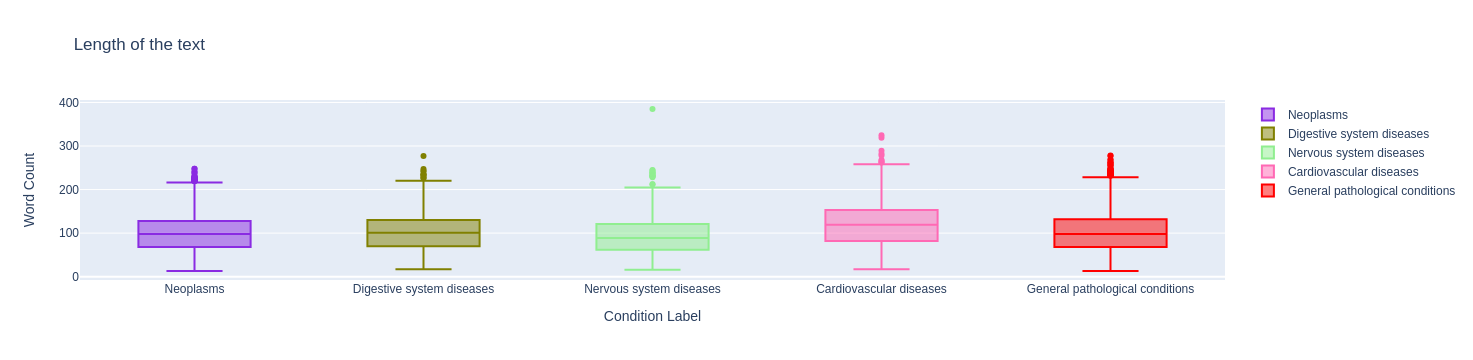

In [100]:
get_quartile_range(df, 'normalize_word_count', [0,1,2,3,4])

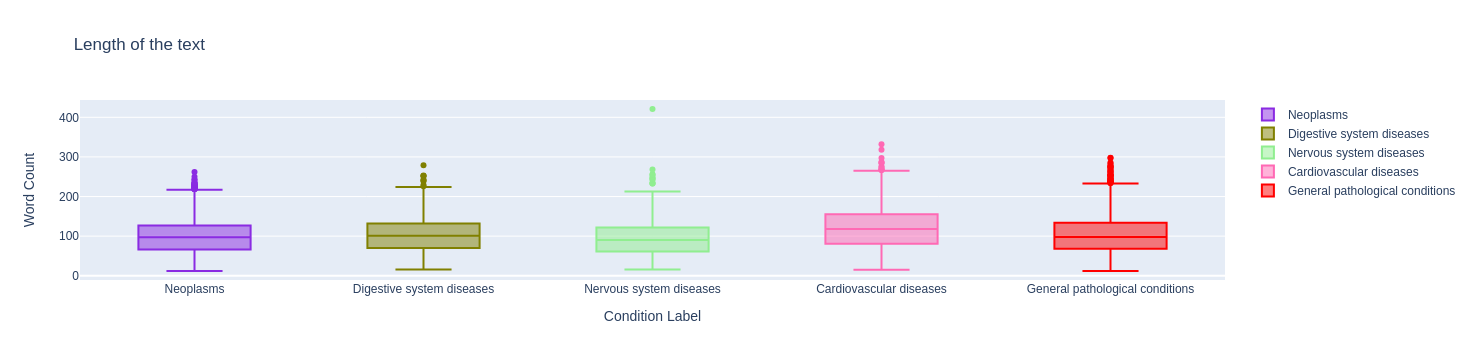

In [101]:
get_quartile_range(df, 'lemma_word_count', [0,1,2,3,4])

* __After implementing the lemmatization method, the overall quartile plot did not change significantly compared to before.__

### Word Cloud

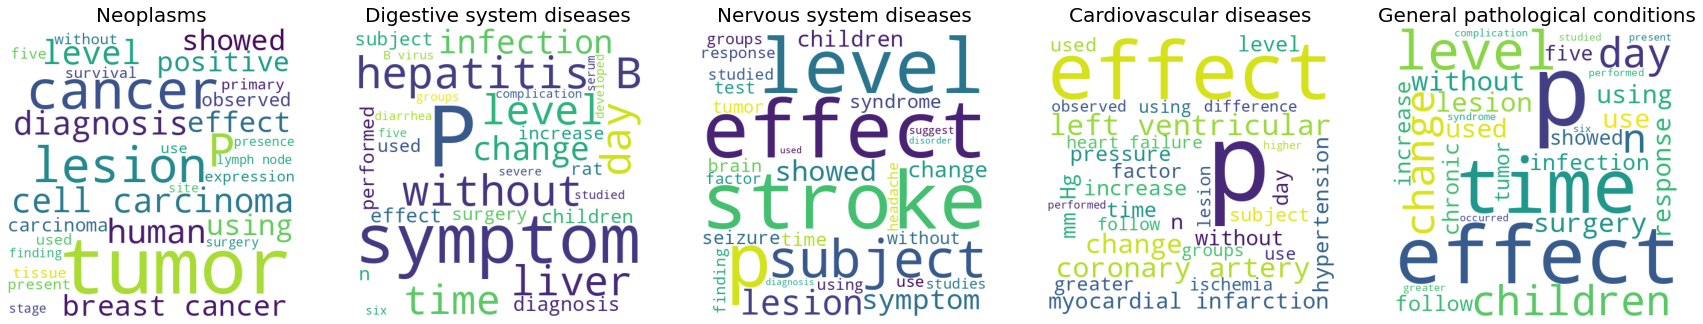

In [102]:

fig, axes = plt.subplots(1, 5, figsize=[30, 30])
for idx, (ax, class_text_clean) in enumerate(zip(axes, [get_clean_text(df['normalize_medical_abstract'][df['condition_label']==0].tolist()),
                                                        get_clean_text(df['normalize_medical_abstract'][df['condition_label']==1].tolist()),
                                                        get_clean_text(df['normalize_medical_abstract'][df['condition_label']==2].tolist()),
                                                        get_clean_text(df['normalize_medical_abstract'][df['condition_label']==3].tolist()),
                                                        get_clean_text(df['normalize_medical_abstract'][df['condition_label']==4].tolist())])):
    visualize_wordcloud(class_text_clean, ax, f'{class_mapping[str(idx)]}', max_words=30)

plt.show()

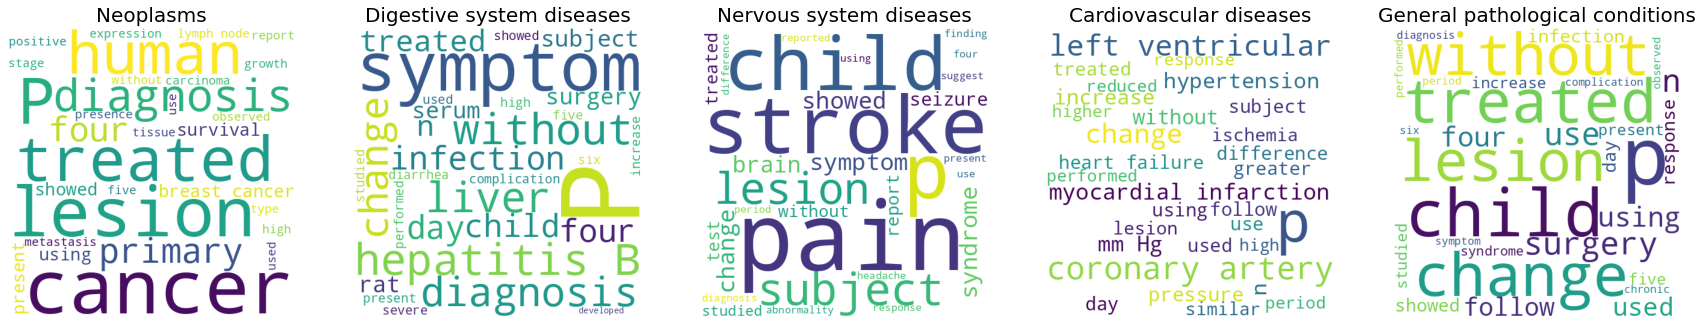

In [103]:

fig, axes = plt.subplots(1, 5, figsize=[30, 30])
for idx, (ax, class_text_clean) in enumerate(zip(axes, [get_clean_text(df['lemma_normalize_medical_abstract'][df['condition_label']==0].tolist()),
                                                        get_clean_text(df['lemma_normalize_medical_abstract'][df['condition_label']==1].tolist()),
                                                        get_clean_text(df['lemma_normalize_medical_abstract'][df['condition_label']==2].tolist()),
                                                        get_clean_text(df['lemma_normalize_medical_abstract'][df['condition_label']==3].tolist()),
                                                        get_clean_text(df['lemma_normalize_medical_abstract'][df['condition_label']==4].tolist())])):
    visualize_wordcloud(class_text_clean, ax, f'{class_mapping[str(idx)]}', max_words=30)

plt.show()

### Bert tokenizer and Format

In [104]:
# Select data to create token
data_raw = df.iloc[5:10]['lemma_normalize_medical_abstract']
data_raw

5    shoulder multiple epiphyseal dysplasia  hundre...
6    management postoperative chylous ascites  repo...
7    Pharmacomechanical thrombolysis angioplasty ma...
8    Color Doppler diagnosis mechanical prosthetic ...
9    Noninvasive diagnosis right-sided extracardiac...
Name: lemma_normalize_medical_abstract, dtype: object

In [105]:
# Load  tokenize nd format function
tokens, cont = tokenize_and_format(data_raw, direction_model='../pre-train/bert-base-uncased')

In [106]:
print('Raw text: ', data_raw[5])

Raw text:  shoulder multiple epiphyseal dysplasia  hundred shoulder assessed 50  multiple epiphyseal dysplasia -third  bilateral symptom  distinct  radiological  emerged minor epiphyseal abnormality developed painful osteoarthritis middle  retained shoulder movement secondary change advanced hatchet head shoulder likewise became painful fifth sixth decade minimal glenohumeral movement early stage


In [107]:
# Tokenizer decode
example_tokens = tokens.decode(cont['input_ids'][0], skip_special_tokens=False)
example_tokens

2024-02-21 15:41:58.578287: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-02-21 15:41:58.578310: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


'[CLS] shoulder multiple epiphyseal dysplasia hundred shoulder assessed 50 multiple epiphyseal dysplasia - third bilateral symptom distinct radiological emerged minor epiphyseal abnormality developed painful osteoarthritis middle retained shoulder movement secondary change advanced hatchet head shoulder likewise became painful fifth sixth decade minimal glenohumeral movement early stage [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [108]:
print('Input token IDS: ', cont['input_ids'][0])
print('Attention mask: ', cont['attention_mask'][0])
print('Token type: ', cont['token_type_ids'][0])

Input token IDS:  tensor([  101,  3244,  3674,  4958, 11514, 10536, 17310,  2140,  1040,  7274,
        24759, 15396,  3634,  3244, 14155,  2753,  3674,  4958, 11514, 10536,
        17310,  2140,  1040,  7274, 24759, 15396,  1011,  2353, 17758, 25353,
        27718,  5358,  5664,  2557,  9966,  6003,  3576,  4958, 11514, 10536,
        17310,  2140, 19470,  3012,  2764,  9145,  9808,  2618, 10441, 15265,
        14778,  2483,  2690,  6025,  3244,  2929,  3905,  2689,  3935, 11300,
         3388,  2132,  3244, 10655,  2150,  9145,  3587,  4369,  5476, 10124,
         8904, 11631, 17897,  7941,  2929,  2220,  2754,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,    

In [109]:
# Updated to add the word "p" to com_words_lemma
com_words.update({"p": ''})
com_words_lemma.update({"p": ''})

In [114]:
df.head()

condition_label                                   medical_abstract  \
0                4  Tissue changes around loose prostheses. A cani...   
1                0  Neuropeptide Y and neuron-specific enolase lev...   
2                1  Sexually transmitted diseases of the colon, re...   
3                0  Lipolytic factors associated with murine and h...   
4                2  Does carotid restenosis predict an increased r...   

  category_condition_label binary_condition_label  word_count  \
0                      [4]        [0, 0, 0, 0, 1]         156   
1                      [0]        [1, 0, 0, 0, 0]         187   
2                      [1]        [0, 1, 0, 0, 0]         256   
3                   [0, 4]        [1, 0, 0, 0, 1]         146   
4                [2, 3, 4]        [0, 0, 1, 1, 1]         233   

                          normalize_medical_abstract  normalize_word_count  \
0  Tissue changes around loose prostheses canine ...                    85   
1  Neuropeptide Y neuron-specific enolase levels ...                   100   
2  Sexually transmitted diseases colon rectum anu...                   137   
3  Lipolytic factors  murine human cancer cachexi...                    84   
4  carotid restenosis predict   late symptoms str...                   132   

                 stemming_normalize_medical_abstract  \
0  tissu chang around loos prosthes canin model i...   
1  neuropeptid y neuron-specif enolas level benig...   
2  sexual transmit diseas colon rectum anu challe...   
3  lipolyt factor associ murin human cancer cache...   
4  carotid restenosi predict increas risk late sy...   

                    lemma_normalize_medical_abstract  lemma_word_count  
0  Tissue change around loose prosthesis canine m...                80  
1  Neuropeptide Y neuron-specific enolase  benign...                95  
2  Sexually transmitted  colon rectum anus challe...               136  
3  Lipolytic   murine human cancer cachexia ident...                77  
4  carotid restenosis predict   late symptom stro...               146

## Finally
* The final step involves preprocessing the entire train-test dataset using the functions analyzed earlier.</br>
* The preprocessed data will be stored in two new files to save time during the training and testing of the model, avoiding the repetition of preprocessing steps multiple times.</br>
* The new files are saved with the names **'preprocessed-medical_tc_train.csv'** and **'preprocessed-medical_tc_test.csv'**.

In [110]:
# # Read and process data train

# train_df = pd.read_csv('../Medical-Abstracts-TC-Corpus/medical_tc_train.csv')

# train_df = normalize_special_text(train_df, 'medical_abstract', 'normalize_medical_abstract')
# train_df = remove_stopwords(train_df, 'normalize_medical_abstract')

# train_df['lemma_normalize_medical_abstract'] = train_df.normalize_medical_abstract.apply(lambda x: stemming_lemma_reprocess(x, type_select='lemma'))

# train_df.normalize_medical_abstract = train_df.normalize_medical_abstract.apply(lambda x: replace_words(x, com_words))
# train_df.lemma_normalize_medical_abstract = train_df.lemma_normalize_medical_abstract.apply(lambda x: replace_words(x, com_words_lemma))

# train_df.drop('medical_abstract', axis=1, inplace=True)
# train_df.rename(columns={'normalize_medical_abstract': 'medical_abstract'}, inplace=True)
# train_df['condition_label'] = train_df['condition_label'].astype(int)
# train_df.head()

In [111]:
# # save training set with new name 'preprocessed-medical_tc_train.csv'
# train_df.to_csv('../Medical-Abstracts-TC-Corpus/preprocessed-medical_tc_train.csv', index=False, index_label=False)

In [112]:
# # Read and process data test

# test_df = pd.read_csv('../Medical-Abstracts-TC-Corpus/medical_tc_test.csv')

# test_df = normalize_special_text(test_df, 'medical_abstract', 'normalize_medical_abstract')
# test_df = remove_stopwords(test_df, 'normalize_medical_abstract')

# test_df['lemma_normalize_medical_abstract'] = test_df.normalize_medical_abstract.apply(lambda x: stemming_lemma_reprocess(x, type_select='lemma'))

# test_df.normalize_medical_abstract = test_df.normalize_medical_abstract.apply(lambda x: replace_words(x, com_words))
# test_df.lemma_normalize_medical_abstract = test_df.lemma_normalize_medical_abstract.apply(lambda x: replace_words(x, com_words_lemma))

# test_df.drop('medical_abstract', axis=1, inplace=True)
# test_df.rename(columns={'normalize_medical_abstract': 'medical_abstract'}, inplace=True)
# test_df['condition_label'] = test_df['condition_label'].astype(int)
# test_df.head()

In [113]:
# # save training set with new name 'preprocessed-medical_tc_test.csv'

# test_df.to_csv('../Medical-Abstracts-TC-Corpus/preprocessed-medical_tc_test.csv', index=False, index_label=False)